# Bank Marketing UCI Modeling

### Necessary imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import optuna
import shap
import modelplotpy as mp
from imblearn.over_sampling import SMOTE

### Reading data

* This data already contains 'ts_month' feature, duplicates are dropped, some bool features have been encoded. These manipulations were conducted in EDA part

In [2]:
def read_data(path: str, files: list, separator=','):
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(path + file, sep=separator))
    return dataframes


path = '../data/'
files = ['bank_data.csv']
bank_data = read_data(path, files)[0]
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,56,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,57,services,married,high.school,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,37,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,40,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,56,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


### Feature Engineering

* Dropping 'duration' feature to avoid leaks

In [3]:
bank_data.drop(columns='duration', inplace=True)

* Using binning for 'age' feature

In [4]:
def make_bins(data, feature, label_names, cut_points):
    data[feature] = pd.cut(data[feature], cut_points, labels=label_names)

    
age_labels = [1, 2, 3, 4]
age_cut_pts = [16, 30, 45, 60, 98]
make_bins(bank_data, 'age', age_labels, age_cut_pts)
bank_data['age'] = bank_data['age'].astype('int8')
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,3,housemaid,married,basic.4y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,3,services,married,high.school,unknown,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,2,services,married,high.school,0,1,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,2,admin.,married,basic.6y,0,0,0,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,3,services,married,high.school,0,0,1,telephone,may,mon,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


* Encoding categorial features

* Encoding consecutive features ('month' and 'day_of_week')

In [5]:
def encode_consecutive(data, feature, encoding):
    data[feature] = data[feature].map(encoding)
    

encode_consecutive(bank_data, 'day_of_week', {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5})
encode_consecutive(bank_data, 'month', {'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12,
                                        'mar': 3, 'apr': 4})
bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,ts_month
0,3,housemaid,married,basic.4y,0,0,0,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
1,3,services,married,high.school,unknown,0,0,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
2,2,services,married,high.school,0,1,0,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
3,2,admin.,married,basic.6y,0,0,0,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0
4,3,services,married,high.school,0,0,1,telephone,5,1,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,0


* Encode 'pdays' feature: 0 - not contacted, 1 - otherwise

In [6]:
def encode_pdays(data):
    data.loc[data.pdays < 999, 'pdays'] = 1
    data.loc[data.pdays == 999, 'pdays'] = 0
    
    
encode_pdays(bank_data)

* Encode 'previous' feature: 0 - not contacted, 1 - contacted once, 2 - contacted more than once 

In [7]:
def encode_previous(data):
    data.loc[data.previous > 1, 'previous'] = 2
    
    
encode_previous(bank_data)

* Encode 'campaign' feature: 1 - contacted once, 2 - contacted twice, 3.5 - contacted 3-4 times, 5 - contacted more times

In [8]:
def encode_campaign(data):
    data.loc[(data.campaign >= 3) & (data.campaign <= 4), 'campaign'] = 3.5
    data.loc[data.campaign >= 5, 'campaign'] = 5
    
    
encode_campaign(bank_data)

* Encode 'empr.var.rate' feature: -2 - -2 <= value <= -1.8, 1 - value >= -1, -3 - otherwise 

In [9]:
def encode_emp_var_rate(data):
    data.loc[(data['emp.var.rate'] >= -2) & (data['emp.var.rate'] <= -1.8), 'emp.var.rate'] = -5
    data.loc[(data['emp.var.rate'] >= -3.5) & (data['emp.var.rate'] < -1), 'emp.var.rate'] = -3
    data.loc[data['emp.var.rate'] == -5, 'emp.var.rate'] = -2
    data.loc[data['emp.var.rate'] >= -1, 'emp.var.rate'] = 1
    
    
encode_emp_var_rate(bank_data)

* Encode other features with One-Hot Encoder

In [10]:
def encode_categorical(features, data):
    for feature in features:
        data = pd.concat([data.drop(feature, axis=1), pd.get_dummies(data[feature], prefix=feature, prefix_sep='_',
                                                                     drop_first=True, dummy_na=False)], axis=1)
    return data
        
cat_features = ['job', 'marital', 'education', 'contact', 'poutcome', 'default', 'housing', 'loan']
bank_data = encode_categorical(cat_features, bank_data)

* Result data

In [11]:
bank_data.sample(10)

,age,month,day_of_week,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,education_unknown,contact_telephone,poutcome_nonexistent,poutcome_success,default_1,default_unknown,housing_1,housing_unknown,loan_1,loan_unknown
16866,3,7,4,2.0,0,0,1.0,93.918,-42.7,4.962,...,0,0,1,0,0,1,1,0,0,0
16758,3,7,4,1.0,0,0,1.0,93.918,-42.7,4.962,...,0,0,1,0,0,0,0,0,0,0
24093,2,11,2,1.0,0,0,1.0,93.200,-42.0,4.343,...,0,1,1,0,0,0,1,0,0,0
7077,2,5,4,1.0,0,0,1.0,93.994,-36.4,4.860,...,0,1,1,0,0,1,1,0,0,0
32621,3,5,1,1.0,0,0,-2.0,92.893,-46.2,1.299,...,0,0,1,0,0,0,1,0,0,0
21738,2,8,2,5.0,0,0,1.0,93.444,-36.1,4.963,...,0,0,1,0,0,0,0,0,0,0
13602,2,7,4,1.0,0,0,1.0,93.918,-42.7,4.963,...,0,0,1,0,0,0,1,0,0,0
29172,1,4,5,2.0,0,0,-2.0,93.075,-47.1,1.405,...,0,0,1,0,0,0,1,0,0,0
1095,1,5,3,2.0,0,0,1.0,93.994,-36.4,4.856,...,0,1,1,0,0,1,0,0,0,0
29938,2,4,1,2.0,0,0,-2.0,93.075,-47.1,1.405,...,0,0,1,0,0,1,0,0,0,0


In [82]:
def smote_transform(X, y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)

    data_res = pd.concat([X_res, y_res], axis=1)
    return data_res

In [27]:
def bank_metric(y_valid, y_pred, normalize=True):
    coeffs = np.array([3, -1.5, -0.25, 0.5])
    cm = confusion_matrix(y_valid, y_pred, labels = [1,0])
    cm = np.reshape(cm, 4)
    if normalize:
        return np.dot(cm, coeffs) / (sum(y_valid) * coeffs[0] + (len(y_valid) - sum(y_valid)) * coeffs[3])
    else:
        return np.dot(cm, coeffs)
    

model = xgb.XGBClassifier()
model.set_params(**{
                    'seed': 0,
                    'n_estimators': 92,
                    'max_depth': 7,
                    'reg_alpha': 1.87,
                    'reg_lambda': 1.12,
                    'min_child_weight': 5,
                    'gamma': 1.51,
                    'learning_rate': 0.32,
                    'colsample_bytree': 0.71,
                    'subsample': 0.55
                   })

"""model = RandomForestClassifier()
model.set_params(**{'bootstrap': 'True',
                    'max_depth': 10,
                    'max_features':'sqrt',
                    'min_samples_leaf': 5,
                    'n_estimators': 200})"""

#model = LogisticRegression(C=0.1, penalty='l2', tol=0.01, max_iter=10000)

X, y = bank_data[bank_data.ts_month <= 20].drop(columns='y'), bank_data[bank_data.ts_month <= 20].y
X_test, y_test = bank_data[bank_data.ts_month > 20].drop(columns='y'), bank_data[bank_data.ts_month > 20].y


from sklearn.model_selection import train_test_split

clf = RandomForestClassifier(random_state=16)

# Classification
X_train, X_test, y_train, y_test = train_test_split(bank_data.drop(columns='y'), bank_data.y, test_size=0.33, random_state=16)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy score without normalization: {accuracy_score(y_test, y_pred)}')

## Min-max normalization
sc = MinMaxScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)
clf.fit(X_train_norm, y_train)
y_pred = clf.predict(X_test_norm)
print(f'Accuracy score with min-max normalization: {accuracy_score(y_test, y_pred)}')

## Standardization
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)
clf.fit(X_train_norm, y_train)
y_pred = clf.predict(X_test_norm)
print(f'Accuracy score with standarization: {accuracy_score(y_test, y_pred)}')


"""sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)"""

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
"""over = SMOTE(sampling_strategy=0.5, random_state=0)
under = RandomUnderSampler(sampling_strategy=0.65, random_state=0)
X, y = over.fit_resample(X, y)
X, y = under.fit_resample(X, y)"""

model.fit(X, y)
pred = model.predict(X_test)
print(f1_score(y_test, pred))

sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

model.fit(X, y)
pred = model.predict(X_test)
print(f1_score(y_test, pred))

Accuracy score without normalization: 0.8851276767974097
Accuracy score with min-max normalization: 0.8853484435940835
Accuracy score with standarization: 0.885054087865185
0.45044247787610625
0.45181255526083114


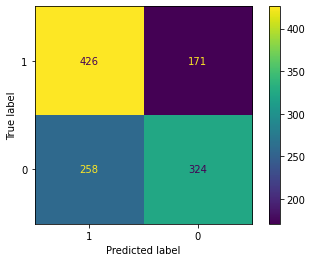

In [15]:
cm = confusion_matrix(y_test, pred, labels = [1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
disp.plot()

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, D

Default scope value no_comparison selected, single evaluation line will be plotted.
The label with smallest class is 1
Target class 1, dataset test data and model xgb.


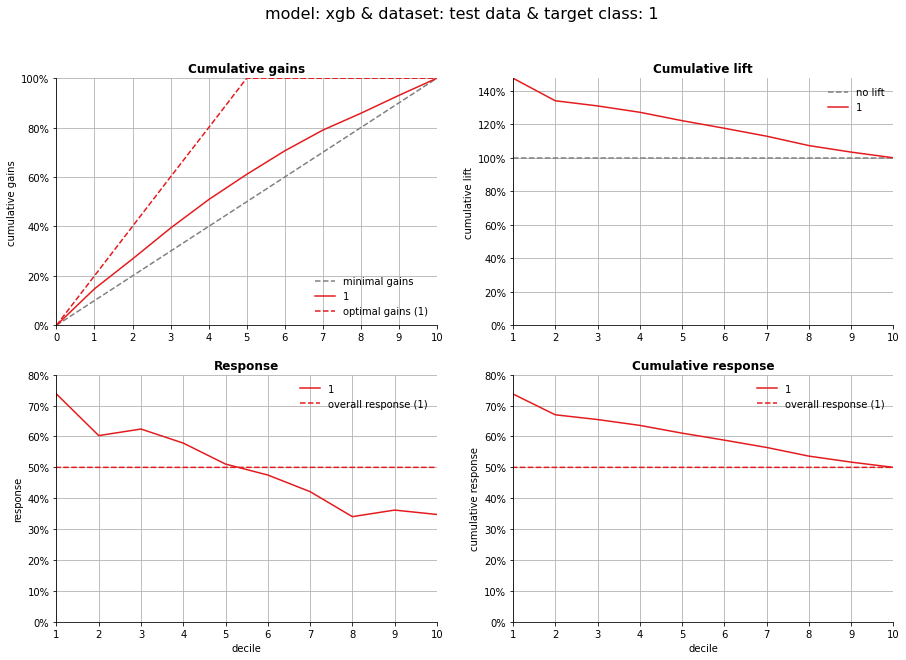

<AxesSubplot:title={'center':'Cumulative gains'}, ylabel='cumulative gains'>

In [17]:
obj = mp.modelplotpy(feature_data = [X, X_test]
                     , label_data = [y, y_test]
                     , dataset_labels = ['train data', 'test data']
                     , models = [model]
                     , model_labels = ['xgb']
                     )

ps = obj.plotting_scope(select_model_label = ['xgb'], select_dataset_label = ['test data'])

mp.plot_all(ps, save_fig = False)

Train scores: [0.9863727680068257, 0.9818317169739733, 0.9805905875233013, 0.9794249308382875, 0.9797243198310708]
Mean train score: 0.9815888646346919
Valid scores: [0.6945951376331115, 0.6482294811968153, 0.759138306405408, 0.709498834498834, 0.7997363506536308]
Mean valid score: 0.72223962207756


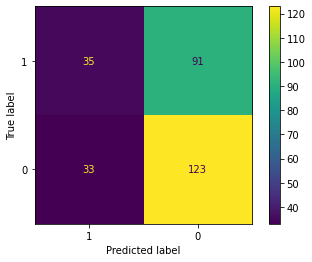

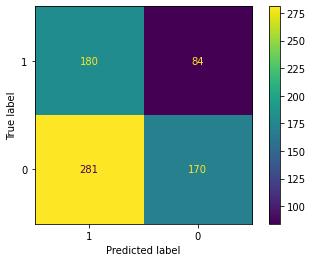

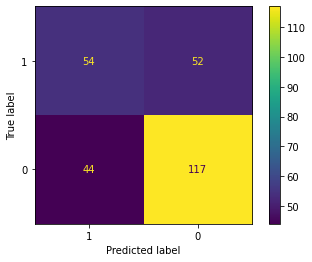

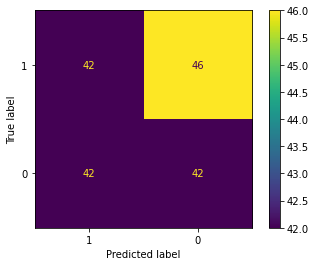

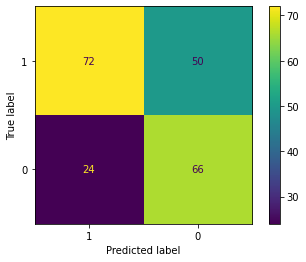

In [109]:
def bank_metric(y_valid, y_pred, normalize=True):
    coeffs = np.array([3, -1.5, 0, 0.5])
    cm = confusion_matrix(y_valid, y_pred, labels = [1,0])
    cm = np.reshape(cm, 4)
    if normalize:
        return np.dot(cm, coeffs) / (sum(y_valid) * coeffs[0] + (len(y_valid) - sum(y_valid)) * coeffs[3])
    else:
        return np.dot(cm, coeffs)


def cumgain_auc_score(y_valid, y_pred, normalize=True):
    def calculate_area(y):
        percentiles = np.array_split(y, 100)
        area = 0
        first = 0
        second = 0
        total = sum(y)
        for p in percentiles:
            second += sum(p) / total
            area += (first + second) * 0.5 * 0.01
            first = second
        return area
    
    y_valid = list(y_valid)
    model = [x[1] for x in sorted(zip(y_pred, y_valid), key=lambda x: x[0], reverse=True)]
    wizard = sorted(y_valid, reverse=True)
    if normalize:
        return calculate_area(model) / calculate_area(wizard)
    else:
        return calculate_area(model)


model = xgb.XGBClassifier()
model.set_params(**{
                    'seed': 0,
                    'n_estimators': 92,
                    'max_depth': 7,
                    'reg_alpha': 1.87,
                    'reg_lambda': 1.12,
                    'min_child_weight': 5,
                    'gamma': 1.51,
                    'learning_rate': 0.32,
                    'colsample_bytree': 0.71,
                    'subsample': 0.55
                   })

"""model = RandomForestClassifier()
model.set_params(**{'bootstrap': 'True',
                    'max_depth': 10,
                    'max_features':'sqrt',
                    'min_samples_leaf': 5,
                    'n_estimators': 200})"""

#model = LogisticRegression(C=0.01, penalty='l2', tol=0.01, max_iter=10000)

train_scores = []
valid_scores = []

start_border = 4
train_border = 19
cv_step = 3

for i in range(start_border + cv_step, train_border + 1, cv_step):
    X_train = bank_data[bank_data['ts_month'] < i].drop(columns=['y']) #MinMaxScaler().fit_transform()
    y_train = bank_data[bank_data['ts_month'] < i]['y']
    X_valid = bank_data[bank_data['ts_month'] == i].drop(columns=['y']) #MinMaxScaler().fit_transform()
    y_valid = bank_data[bank_data['ts_month'] == i]['y']
    
    sm = SMOTE(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    train_scores.append(cumgain_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    valid_scores.append(cumgain_auc_score(y_valid, model.predict_proba(X_valid)[:,1]))
    """cm = confusion_matrix(y_train, model.predict(X_train), labels = [1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot()"""
    cm = confusion_matrix(y_valid, model.predict(X_valid), labels = [1, 0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
    disp.plot()
print('Train scores:', train_scores)
print('Mean train score:', np.mean(train_scores))
print('Valid scores:', valid_scores)
print('Mean valid score:', np.mean(valid_scores))

In [110]:
X, y = bank_data[bank_data.ts_month < 23].drop(columns='y'), bank_data[bank_data.ts_month < 23].y
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
X_test, y_test = bank_data[bank_data.ts_month >= 23].drop(columns='y'), bank_data[bank_data.ts_month >= 23].y
model.fit(X, y)
pred = model.predict_proba(X_test)[:,1]
cumgain_auc_score(y_test, pred)

0.7930522879972866

In [113]:
X.job_housemaid.unique()

array([1, 0], dtype=uint8)

In [106]:
X.duplicated().sum()

(72406, 42)

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
In a future version, D

Default scope value no_comparison selected, single evaluation line will be plotted.
The label with smallest class is 0
Target class 0, dataset test data and model xgb.


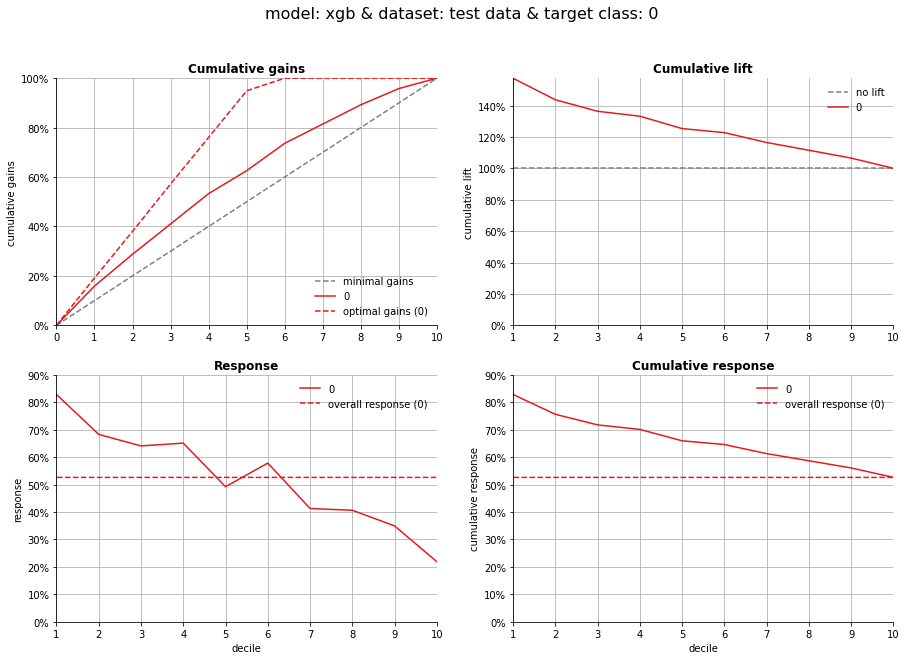

<AxesSubplot:title={'center':'Cumulative gains'}, ylabel='cumulative gains'>

In [101]:
obj = mp.modelplotpy(feature_data = [X, X_test]
                     , label_data = [y, y_test]
                     , dataset_labels = ['train data', 'test data']
                     , models = [model]
                     , model_labels = ['xgb']
                     )

ps = obj.plotting_scope(select_model_label = ['xgb'], select_dataset_label = ['test data'])

mp.plot_all(ps, save_fig = False)

### Model Selection & HPO

* Train/valid/test split: I'll split data according to 'ts_month' feature
* Train: 0 - 19 months
* Valid: 20-22 month
* Test: 23-25 month

In [71]:
class TimeSeriesCycle:
    def __init__(self,
                 data: pd.DataFrame,
                 models_with_params: dict,
                 metric: object,
                 start_border: int,
                 train_border: int,
                 valid_border: int,
                 test_border: int,
                 cv_step: int,
                 optuna_trials: int
                ):
        self.data = data
        self.models_with_params = models_with_params
        self.metric = metric
        self.start_border = start_border
        self.train_border = train_border
        self.valid_border = valid_border
        self.test_border = test_border    
        self.cv_step = cv_step
        self.optuna_trials = optuna_trials
        self.best_estimators = []
        self.final_estimator = None
        self.final_fitted_estimator = None
        self.shap_values = None
        
   
    def evaluate_model(self, model, params):
        def objective(trial):
            model.set_params(**params(trial))
            train_scores = []
            valid_scores = []
            for i in range(self.start_border + self.cv_step, self.train_border + 1, self.cv_step):
                X_train = self.data[self.data['ts_month'] < i].drop(columns=['y'])
                y_train = self.data[self.data['ts_month'] < i]['y']
                X_valid = self.data[self.data['ts_month'] == i].drop(columns=['y'])
                y_valid = self.data[self.data['ts_month'] == i]['y']

                model.fit(X_train, y_train)
                train_scores.append(self.metric(y_train, model.predict_proba(X_train)[:,1]))
                valid_scores.append(self.metric(y_valid, model.predict_proba(X_valid)[:,1]))
            print('Train scores:', train_scores)
            print('Mean train score:', np.mean(train_scores))
            return np.mean(valid_scores)
        
        
        start = time.time()
        study_name = 'study'
        study = optuna.create_study(study_name=study_name, direction='maximize', sampler=optuna.samplers.TPESampler())
        study.optimize(objective, n_trials=self.optuna_trials, show_progress_bar=True, gc_after_trial=True)
        end = time.time()
        
        print('Best score: {}'.format(study.best_value))
        print('Best params: {}'.format(study.best_params))
        print('Taken time: {}'.format(int(end - start)))
        
        self.best_estimators.append((model, study.best_params))
    
    
    def compare_models(self):
        for model, params in self.models_with_params.items():
            print('Hyperparameters tuning for', type(model).__name__)
            self.evaluate_model(model, params)
            print('Tuning completed for {}!'.format(type(model).__name__))

            
        X_train = self.data[self.data['ts_month'] <= self.train_border].drop(columns=['y'])
        y_train = self.data[self.data['ts_month'] <= self.train_border]['y']
        X_valid = self.data[(self.data['ts_month'] > self.train_border) & (self.data['ts_month'] <= self.valid_border)].drop(columns=['y'])
        y_valid = self.data[(self.data['ts_month'] > self.train_border) & (self.data['ts_month'] <= self.valid_border)]['y']
        
        valid_scores = []
        for model, params in self.best_estimators:
            model.set_params(**params)
            model.fit(X_train, y_train)
            
            train_score = self.metric(y_train, model.predict_proba(X_train))
            valid_score = self.metric(y_valid, model.predict_proba(X_valid))
            print('Train score for {} ='.format(type(model).__name__), train_score)
            print('Validation score for {} = '.format(type(model).__name__), valid_score)
            valid_scores.append(valid_score)
            
        self.final_estimator = self.best_estimators[np.argmax(valid_scores)]
    
    
    def get_predictions(self):
        start = time.time()
        
        model, params = self.final_estimator
        model.set_params(**params)
        print('Final model: ' + str(model))
        X = self.data[self.data['ts_month'] <= self.valid_border].drop(columns=['y'])
        y = self.data[self.data['ts_month'] <= self.valid_border]['y']
        print('Fitting...')
        model.fit(X, y)
        X_test = self.data[(self.data['ts_month'] > self.valid_border) & (self.data['ts_month'] <= self.test_border)].drop(columns=['y'])
        y_test = self.data[(self.data['ts_month'] > self.valid_border) & (self.data['ts_month'] <= self.test_border)]['y']
        print('Test score for {} ='.format(type(model).__name__), self.metric(y_test, model.predict_proba(X_test)))
        
        end = time.time()
        print('Took ' + str(int(end - start)) + ' seconds to get final predictions')
        self.final_fitted_estimator = model
    
    
    def explain_model(self, model, data='train'):
        explainer = shap.Explainer(model)
        if data == 'train':
            X = self.data[self.data['ts_month'] <= self.valid_border].sample(1000, random_state=42).drop(columns=['y'])
        else:
            X = self.data[self.data['ts_month'] == self.test_border].drop(columns=['y'])
        self.shap_values = explainer(X)
        shap.summary_plot(self.shap_values, X)

In [72]:
xgb_model = xgb.XGBClassifier()
def xgb_params(trial):
    params = {
        'random_state': 0,
        'n_estimators': trial.suggest_int('n_estimators', 1, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 4),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
        'gamma': trial.suggest_float('gamma', 0, 4),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.5, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'subsample': trial.suggest_float('subsample', 0.4, 0.9),
        'nthread': -1
    }
    return params

rf_model = RandomForestClassifier()
def rf_params(trial):
    params = {
        'random_state': 42,
        'bootstrap': trial.suggest_categorical('bootstrap', ['True', 'False']),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'n_estimators': trial.suggest_int('n_estimators', 1, 300),
        'n_jobs': -1
    }
    return params

tsc = TimeSeriesCycle(data=bank_data,
                      models_with_params={#rf_model: rf_params,
                                          xgb_model: xgb_params
                                          #log_reg_model: log_reg_params,
                                          #svm_model: svm_params
                                          },
                      metric=cumgain_auc_score,
                      start_border=4,
                      train_border=19,
                      valid_border=22,
                      test_border=25,
                      cv_step=3,
                      optuna_trials=100 #20
                     )

In [75]:
tsc.compare_models()

[I 2022-11-30 20:57:45,404] A new study created in memory with name: study


Hyperparameters tuning for XGBClassifier


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

Train scores: [0.7274282499454621, 0.7782706138007796, 0.8029083945276435, 0.8217541388660659, 0.8332389538063879]
Mean train score: 0.7927200701892677
[I 2022-11-30 20:57:55,884] Trial 0 finished with value: 0.7428046655709364 and parameters: {'n_estimators': 78, 'max_depth': 11, 'reg_alpha': 1.793740550613614, 'reg_lambda': 0.8180010100605586, 'min_child_weight': 5, 'gamma': 0.9027021352797622, 'learning_rate': 0.08658436105096466, 'colsample_bytree': 0.569019867407274, 'subsample': 0.587445467207495}. Best is trial 0 with value: 0.7428046655709364.
Train scores: [0.6847092682814809, 0.7458853276520021, 0.7813537605224354, 0.7997604408370117, 0.8170166975983507]
Mean train score: 0.7657450989782563
[I 2022-11-30 20:58:04,386] Trial 1 finished with value: 0.7409071864716117 and parameters: {'n_estimators': 99, 'max_depth': 10, 'reg_alpha': 2.8309568779781493, 'reg_lambda': 1.360970323771391, 'min_child_weight': 1, 'gamma': 1.8241649052963744, 'learning_rate': 0.06889370733303403, 'col

Train scores: [0.44978165938864584, 0.5513607737052589, 0.6278191863108438, 0.6691946779343739, 0.6958416518208353]
Mean train score: 0.5987995898319916
[I 2022-11-30 20:59:21,706] Trial 15 finished with value: 0.7370176581575129 and parameters: {'n_estimators': 1, 'max_depth': 12, 'reg_alpha': 3.993618476607997, 'reg_lambda': 1.1597536881606794, 'min_child_weight': 2, 'gamma': 1.9996879361210491, 'learning_rate': 0.23981048681128236, 'colsample_bytree': 0.5911102038395724, 'subsample': 0.4101248216271669}. Best is trial 11 with value: 0.7537169299405193.
Train scores: [0.6299499787591514, 0.7096902582351976, 0.7503272116060232, 0.7750912642163009, 0.7877549108354583]
Mean train score: 0.7305627247304263
[I 2022-11-30 20:59:23,526] Trial 16 finished with value: 0.7513626739788428 and parameters: {'n_estimators': 27, 'max_depth': 3, 'reg_alpha': 3.2725250687241108, 'reg_lambda': 1.7402454984683629, 'min_child_weight': 0, 'gamma': 3.3792793432367487, 'learning_rate': 0.384898984364432, '

Train scores: [0.6386836032132995, 0.7136192302535097, 0.7535958833335623, 0.7774597700111644, 0.7879174916263999]
Mean train score: 0.7342551956875872
[I 2022-11-30 21:00:10,576] Trial 30 finished with value: 0.7523171584126057 and parameters: {'n_estimators': 23, 'max_depth': 4, 'reg_alpha': 3.128693735043887, 'reg_lambda': 1.248548588823545, 'min_child_weight': 3, 'gamma': 2.0716209936577963, 'learning_rate': 0.30016610362318447, 'colsample_bytree': 0.46934660993419164, 'subsample': 0.507311064748667}. Best is trial 11 with value: 0.7537169299405193.
Train scores: [0.6406584280241412, 0.7150580087390889, 0.7544018571841886, 0.7784649554438005, 0.791381289155447]
Mean train score: 0.7359929077093332
[I 2022-11-30 21:00:12,750] Trial 31 finished with value: 0.7536639916306163 and parameters: {'n_estimators': 23, 'max_depth': 4, 'reg_alpha': 2.077655629329784, 'reg_lambda': 1.1201578078256809, 'min_child_weight': 3, 'gamma': 2.1642549516391494, 'learning_rate': 0.31111448383164153, 'co

Train scores: [0.6451515371867925, 0.7189061026768513, 0.7542571952109993, 0.7770384347998803, 0.7926681574498506]
Mean train score: 0.7376042854648748
[I 2022-11-30 21:00:56,352] Trial 45 finished with value: 0.7614573014819419 and parameters: {'n_estimators': 41, 'max_depth': 4, 'reg_alpha': 2.9556963336243007, 'reg_lambda': 0.7473342415672033, 'min_child_weight': 3, 'gamma': 3.6049407024205977, 'learning_rate': 0.23865222203615366, 'colsample_bytree': 0.4292454068917169, 'subsample': 0.4466016039058949}. Best is trial 45 with value: 0.7614573014819419.
Train scores: [0.631649246619643, 0.7084558033215341, 0.7478679580618046, 0.7706431682000254, 0.7856551385863453]
Mean train score: 0.7288542629578705
[I 2022-11-30 21:00:58,683] Trial 46 finished with value: 0.7566963018520522 and parameters: {'n_estimators': 43, 'max_depth': 3, 'reg_alpha': 2.9242322265494565, 'reg_lambda': 0.6597364522979221, 'min_child_weight': 4, 'gamma': 3.9969010886100658, 'learning_rate': 0.23183112232056247, 

Train scores: [0.6233901924688747, 0.7010916412503746, 0.7480195087003841, 0.771594181962639, 0.7878899355601384]
Mean train score: 0.7263970919884822
[I 2022-11-30 21:01:36,703] Trial 60 finished with value: 0.739919127093862 and parameters: {'n_estimators': 18, 'max_depth': 12, 'reg_alpha': 3.23620958177388, 'reg_lambda': 1.0237450608486425, 'min_child_weight': 5, 'gamma': 3.6116662169232034, 'learning_rate': 0.16837931828600472, 'colsample_bytree': 0.8138654220864188, 'subsample': 0.5006244248598085}. Best is trial 45 with value: 0.7614573014819419.
Train scores: [0.6468661137667479, 0.7181696864697356, 0.7576498629155584, 0.7784679649810242, 0.7892512052334478]
Mean train score: 0.7380809666733028
[I 2022-11-30 21:01:39,139] Trial 61 finished with value: 0.7544751486548131 and parameters: {'n_estimators': 38, 'max_depth': 4, 'reg_alpha': 2.473354339319651, 'reg_lambda': 0.5491495284910656, 'min_child_weight': 3, 'gamma': 3.1838867147775174, 'learning_rate': 0.23089868483445203, 'co

Train scores: [0.6371833487058384, 0.7120229523479114, 0.7544879655015629, 0.7765990423652551, 0.7921280585511291]
Mean train score: 0.7344842734943393
[I 2022-11-30 21:02:23,547] Trial 75 finished with value: 0.7530816603713554 and parameters: {'n_estimators': 54, 'max_depth': 3, 'reg_alpha': 3.86248001418167, 'reg_lambda': 0.5749493148066854, 'min_child_weight': 2, 'gamma': 3.755478380680097, 'learning_rate': 0.28378032410667037, 'colsample_bytree': 0.4566808153190143, 'subsample': 0.4006769996085159}. Best is trial 45 with value: 0.7614573014819419.
Train scores: [0.6335551821928969, 0.7108310648450644, 0.7498553380268104, 0.7713835143569971, 0.7849579701099345]
Mean train score: 0.7301166139063406
[I 2022-11-30 21:02:26,646] Trial 76 finished with value: 0.7557545536034909 and parameters: {'n_estimators': 47, 'max_depth': 3, 'reg_alpha': 3.7034161386663023, 'reg_lambda': 0.7108387140424863, 'min_child_weight': 4, 'gamma': 3.997861469285159, 'learning_rate': 0.25887730086694716, 'co

Train scores: [0.571440052968169, 0.6698897291222808, 0.7246497113649202, 0.7143287076746204, 0.7667847444105955]
Mean train score: 0.6894185891081172
[I 2022-11-30 21:03:06,743] Trial 90 finished with value: 0.7495851379083762 and parameters: {'n_estimators': 4, 'max_depth': 4, 'reg_alpha': 3.9017724477888596, 'reg_lambda': 0.3626738824241865, 'min_child_weight': 3, 'gamma': 3.2703371444504983, 'learning_rate': 0.38359606125016754, 'colsample_bytree': 0.5197256642900504, 'subsample': 0.4983871121905903}. Best is trial 45 with value: 0.7614573014819419.
Train scores: [0.6174274462376903, 0.7009341418303553, 0.7382858245043596, 0.7657165557652189, 0.7749936965498422]
Mean train score: 0.7194715329774933
[I 2022-11-30 21:03:08,753] Trial 91 finished with value: 0.7579698195603243 and parameters: {'n_estimators': 20, 'max_depth': 3, 'reg_alpha': 2.734724510404029, 'reg_lambda': 0.4732201121433834, 'min_child_weight': 3, 'gamma': 3.904252204974985, 'learning_rate': 0.24380333367407817, 'co

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
tsc.get_predictions()

### Testing

### Model explainability

### Business understanding

In [ ]:
def create_categorical_labels(features, data):
    for feature in features:
        data[feature] = LabelEncoder().fit_transform(data[feature])
        

cat_features = ['job', 'marital', 'education', 'contact', 'poutcome']
create_categorical_labels(cat_features, bank_data)

custom: 'campaign', 'previous', 'pdays', 'emp.var.rate', 'age'

label: 

one-hot: 'job', 'marital', 'education', 'contact', 'poutcome', loan housing default

consecutive: 'month', 'day_of_week'

leave: 'poutcome', 'cons.price.idx' - scaler mb, 'cons.conf.idx', 'euribor3m', 'nr.employed', 

deal with outliers : loan housin gefault ||| job marital education

In [31]:
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'ts_month'],
      dtype='object')

In [15]:
bank_data['cons.price.idx']

0        0.722628
1        0.722628
2        0.722628
3        0.722628
4        0.722628
           ...   
41171    2.058076
41172    2.058076
41173    2.058076
41174    2.058076
41175    2.058076
Name: cons.price.idx, Length: 41176, dtype: float64

In [20]:
bank_data['cons.price.idx'] = MinMaxScaler().fit_transform(bank_data['cons.price.idx'].values.reshape(-1,1)).round(decimals=2)

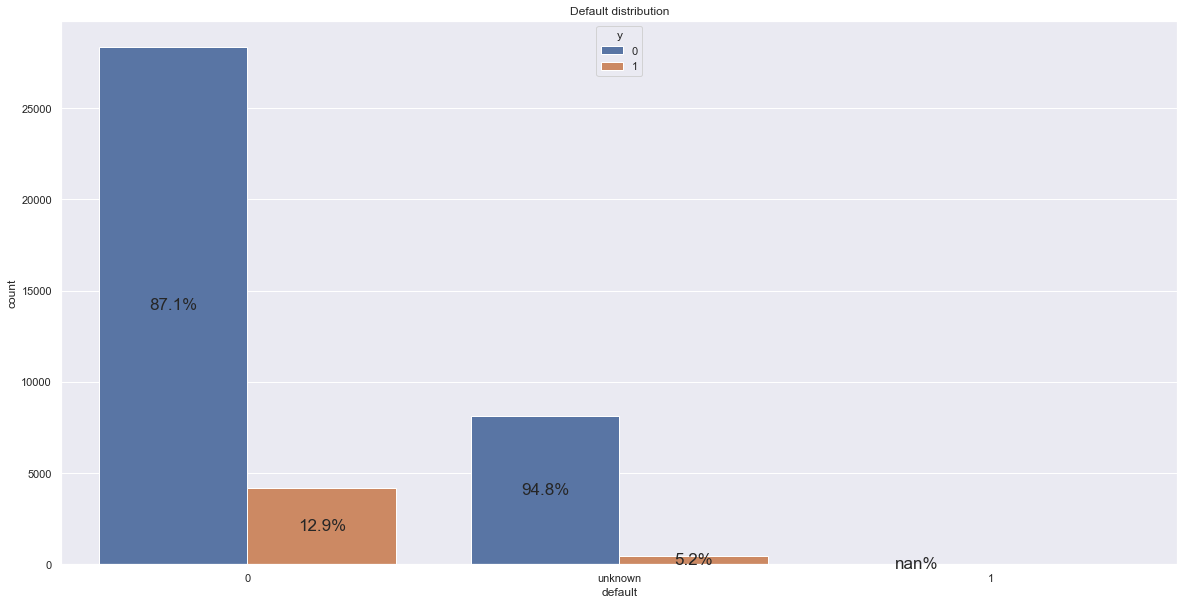

In [33]:
def create_countplot(feature, hue, fontsize, data):
    def place_percentage(patch, percentage, ax):
        x = patch.get_x() + patch.get_width() / 2
        y = patch.get_height() / 2
        ax.annotate(percentage, xy=(x, y), fontsize=fontsize, ha='center', va='center')
        

    sns.set(style="darkgrid")
    plt.figure(figsize=(20, 10))
    ax = sns.countplot(x=feature, hue=hue, data=data)
    plt.title('{} distribution'.format(feature.capitalize()))
    for i in range(len(ax.patches) // 2):
        total = ax.patches[i].get_height() + ax.patches[i + len(ax.patches) // 2].get_height()
        place_percentage(ax.patches[i], '{:.1f}%'.format(100 * ax.patches[i].get_height() / total), ax)
        place_percentage(ax.patches[i + len(ax.patches) // 2], '{:.1f}%'.format(100 * ax.patches[i + len(ax.patches) // 2].get_height() / total), ax)
    plt.show()
    

create_countplot('default', 'y', 17, bank_data)

In [27]:
for i in bank_data.euribor3m.value_counts():
    print(i)

2868
2611
2487
1902
1210
1175
1169
1070
1044
1013
991
895
892
839
822
820
788
756
733
689
676
643
637
620
610
587
581
544
538
537
520
491
482
422
395
373
340
303
254
252
215
180
172
145
139
135
128
124
110
103
103
98
98
95
87
86
82
82
81
81
79
78
74
70
67
65
62
60
57
54
54
50
50
49
48
45
44
44
43
39
39
38
38
37
37
35
35
35
35
35
35
34
33
33
31
31
31
30
30
29
29
28
27
27
27
27
26
26
26
25
25
25
24
24
24
23
23
23
23
23
22
22
22
22
22
22
21
21
21
21
21
21
21
20
20
20
20
20
20
20
20
20
19
19
19
18
18
18
18
18
18
18
17
17
17
17
17
17
17
17
16
16
16
16
16
16
16
16
15
15
15
15
14
14
14
14
13
13
13
13
13
13
13
13
13
12
12
12
12
12
11
11
11
11
11
11
11
11
10
10
10
10
10
10
10
10
10
10
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
8
8
8
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
